# **1. Computational Graph**

> This code is adapted from course **NN from Zero to Hero** - Andrej Karpathy

- We want to create a computational graph.
- An operation node in computational graph
  - receives 1 or 2 values from other nodes
  - return a single value

In [1]:
# Run this library
import math
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## **Task 1**
---

- Create a Class called `Value`
- Initialize a single value when creating `Value` object.
- Return `Value(data=<data>)` if you call the object.

In [2]:
# Write your code in here
class Value:
    def __init__(self, data):
        self.data = data

    def __repr__(self):
        return f'Value(data={self.data})'

Test the code

In [3]:
a = Value(3)
print(a)

Value(data=3)


In [4]:
b = Value(-4.0)
print(b)

Value(data=-4.0)


## **Task 2**
---

- Update the `Value` class
- Create basic operations e.g. summation and multiplication
- Store
  - The label data
  - The children
  - The type of operation as class parameters.
- Return the calculation results as a `Value` object
- Perform basic operation

In [5]:
# Write your code in here
class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self):
        return f'Value(data={self.data})'

    def __add__(self, other):
        out = Value(data = self.data + other.data,
                    _children = (self, other),
                    _op = '+')

        return out

    def __mul__(self, other):
        out = Value(data = self.data * other.data,
                    _children = (self, other),
                    _op = '*')

        return out


Test the code

In [6]:
a = Value(data=4.0, label='a')
b = Value(data=3.0, label='b')

c = a + b; c.label = 'c'

print('Operation result          :', c)
print('Operation type            :', c._op)
print('Value label               :', c.label)
print('Previous value to operate :', c._prev)

Operation result          : Value(data=7.0)
Operation type            : +
Value label               : c
Previous value to operate : {Value(data=3.0), Value(data=4.0)}


In [7]:
a = Value(data=4.0, label='a')
b = Value(data=-3.0, label='b')

c = a * b; c.label = 'c'

print('Operation result          :', c)
print('Operation type            :', c._op)
print('Value label               :', c.label)
print('Previous value to operate :', c._prev)

Operation result          : Value(data=-12.0)
Operation type            : *
Value label               : c
Previous value to operate : {Value(data=4.0), Value(data=-3.0)}


## **Task 3**
---

- Perform the operation
- Create a function to `trace` the nodes that being operated & edges that define operation between two nodes.

We create a computational graph, say

$$
\begin{align*}
C &= A + B \\
E &= C * D
\end{align*}
$$

In [8]:
# Let
A = Value(data=4.0, label='A')
B = Value(data=3.0, label='B')
D = Value(data=2.0, label='D')

In [9]:
# 1st operation
C = A + B; C.label = 'C'
print(C)

# 2nd operation
E = C * D; E.label = 'E'
print(E)

Value(data=7.0)
Value(data=14.0)


We backtrack the children

In [10]:
# Children of E
for child in E._prev:
    print(child)

Value(data=2.0)
Value(data=7.0)


Great! The children of `E` is `C` and `D` which have value of `7.0` and `2.0` respectively.

In [11]:
# Children of children of E
for child in E._prev:
    if len(child._prev)==0:
        print(f'Child - {child} does not have any children')
    else:
        print(f'Child - {child} does have children:')

    for grandchild in child._prev:
        print(' -', grandchild)

Child - Value(data=2.0) does not have any children
Child - Value(data=7.0) does have children:
 - Value(data=3.0)
 - Value(data=4.0)


Great! We can extract the grand children.

Now, we can optimize this and create a tracing function from the root (the final variable)

In [12]:
def trace(root):
    """Trace all noeds and edges in a graph"""
    nodes = set()
    edges = set()

    # A local function
    def build(node):
        # If node is not in nodes, then trace the node
        if node not in nodes:
            # Store node to nodes
            nodes.add(node)

            # Iterate to find child of previous nodes
            for child in node._prev:
                # Add edges that connect node & child
                edges.add((child, node))

                # Build the child node recursively
                build(child)

    # Start building the node recursively from the final node
    build(root)

    return nodes, edges


Let's validate

In [13]:
nodes, edges = trace(root = E)

In [14]:
nodes

{Value(data=14.0),
 Value(data=2.0),
 Value(data=3.0),
 Value(data=4.0),
 Value(data=7.0)}

In [15]:
edges

{(Value(data=2.0), Value(data=14.0)),
 (Value(data=3.0), Value(data=7.0)),
 (Value(data=4.0), Value(data=7.0)),
 (Value(data=7.0), Value(data=14.0))}

## **Task 4**
---

- Draw the computational graph

Now, use this library to draw the computational graph

In [ ]:
# Install the library first
!sudo apt-get update
!sudo apt-get install graphviz -y
!pip install graphviz

In [17]:
from graphviz import Digraph

In [18]:
def draw_dot(root):
    """Draw the computational graph by backtracing the operation"""
    # Create a workspace
    dot = Digraph(format='svg',
                  graph_attr={'rankdir': 'LR'})

    # Trace the nodes & edges from computational graph
    nodes, edges = trace(root)

    # Draw
    for node_ in nodes:
        uid = str(id(node_))

        # Create a rectangular node
        dot.node(name = uid,
                 label = '{ %s | data %.4f }' % (node_.label, node_.data),
                 shape = 'record')

        # Create operator (node & edge)
        if node_._op:
            # Create an operation node
            dot.node(name = uid + node_._op,
                     label = node_._op)

            # Connect edge between operation nodes to next value nodes
            dot.edge(tail_name = uid + node_._op,
                     head_name = uid)

    # Create edge for value nodes to operation nodes
    for node_1, node_2 in edges:
        dot.edge(tail_name = str(id(node_1)),
                 head_name = str(id(node_2)) + node_2._op)

    return dot


Let's draw our computational graph

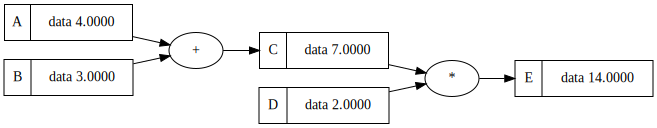

In [19]:
draw_dot(E)

## **Exercise**
---

Given a linear regression function

$$
y = w_{0} + w_{1}x_{1} + w_{2}x_{2}
$$

Your tasks are:
1. Create a computational graph to find $y$ where
  - $w = [0.9, 0.01, 0.2]$
  - $x = [1.0, -1.0]$

2. Draw the computational graph

In [20]:
# Create an input
x1 = Value(data=1.0, label='x1')
x2 = Value(data=-1.0, label='x2')

w0 = Value(data=0.9, label='w0')
w1 = Value(data=0.01, label='w1')
w2 = Value(data=0.2, label='w2')

In [21]:
# Create a computational graph
w1x1 = w1 * x1; w1x1.label = 'w1x1'
w2x2 = w2 * x2; w2x2.label = 'w2x2'
w1x1w2x2 = w1x1 + w2x2; w1x1w2x2.label = 'w1x1 + w2x2'

y = w0 + w1x1w2x2; y.label = 'y'
y

Value(data=0.71)

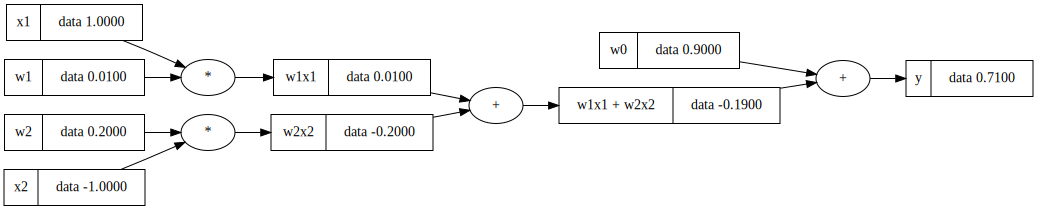

In [22]:
# Draw the computational graph
draw_dot(root = y)

# **Automatic Differentiation**
---

Our objective
- We can obtain the gradient of root (final results) to each node inside the computational graph.
- To do that, we can backtrack the operation through computational graph

## **Task 1**
---

- Find the gradient of a function at is minimum points
- Say

$$
f(x) = 5x^{2} - 10x + 3
$$

---
Analitically, minimum value of $f(x)$ can be obtained by solving

$$
\cfrac{d f(x)}{dx} = 0
$$

Thus

$$
\begin{align*}
\cfrac{d f(x)}{dx} &= 0 \\
0 &= 2.5.x - 10 \\
10x &= 10 \\
x_{\text{optimum}} &= 1.0
\end{align*}
$$

To do it computationally,

In [23]:
def f(x):
    return (5*(x**2)) - (10*x) + 3

In [24]:
# Define some x & y
xs = np.arange(-5, 5, 0.25)
ys = f(xs)

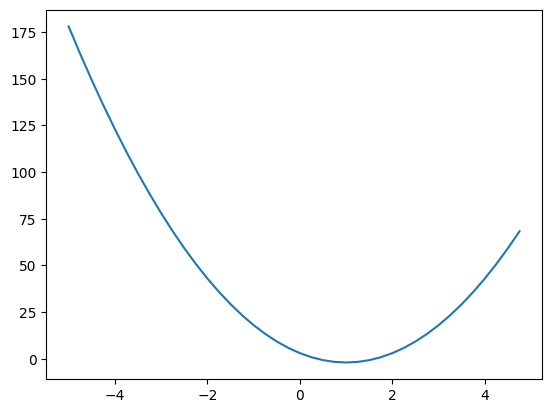

In [25]:
# Plot
plt.plot(xs, ys)

We can see that the minimum value of $f(x)$ is near $1.0$

To find it's gradient computationally, we can use the newton's method

$$
\cfrac{d f(x)}{dx}
=
\cfrac
{f(x+h) - f(x)}
{h}
$$

In [26]:
h = 0.000001
x = 1.0

grad = (f(x+h) - f(x)) / h
grad

5.000444502911705e-06

## **Task 2**
---

- Find gradient of a more complex operations

- Say,

$$
d = a + b.c
$$

---
Analytically,

$$
\begin{align*}
\cfrac{\partial d}{\partial a} &= 1.0 \\
\cfrac{\partial d}{\partial b} &= c \\
\cfrac{\partial d}{\partial c} &= b \\
\end{align*}
$$

---
Computationally, we can use $h$

First, gradient of $a$

$$
\cfrac{\partial d}{\partial a} = 1.0
$$

In [27]:
# Define h
h = 0.0001

# Inputs
a = 3.0
b = -4.0
c = 8.0

# obtain f(x)
d1 = a + b*c

# Update a by h
a += h

# obtain f(x+h)
d2 = a + b*c

# find the grad (slope)
slope = (d2-d1) / h
slope

0.9999999999976694

Find gradient of $b$

$$
\cfrac{\partial d}{\partial b} = c
$$

In [28]:
# Define h
h = 0.0001

# Inputs
a = 3.0
b = -4.0
c = 8.0

# obtain f(x)
d1 = a + b*c

# Update b by h
b += h

# obtain f(x+h)
d2 = a + b*c

# find the grad (slope)
slope = (d2-d1) / h
slope

8.000000000016882

Find gradient of $c$

$$
\cfrac{\partial d}{\partial c} = b
$$

In [29]:
# Define h
h = 0.0001

# Inputs
a = 3.0
b = -4.0
c = 8.0

# obtain f(x)
d1 = a + b*c

# Update c by h
c += h

# obtain f(x+h)
d2 = a + b*c

# find the grad (slope)
slope = (d2-d1) / h
slope

-3.9999999999906777

Great!

## **Task 3**
---

- Find gradient of a more complex operations using `Value` class

- Say,

$$
d = a + b.c
$$

---
The gradient of $a$

In [30]:
# Define h
h = 0.0001

# Inputs
a = Value(data=3.0, label='a')
b = Value(data=-4.0, label='b')
c = Value(data=8.0, label='c')

# obtain f(x)
d1 = a + b*c; d1.label = 'd1'

# Update a by h
a.data += h

# obtain f(x+h)
d2 = a + b*c; d2.label = 'd2'

# find the grad (slope)
slope = (d2.data - d1.data) / h
slope

0.9999999999976694

---
The gradient of $b$

In [31]:
# Define h
h = 0.0001

# Inputs
a = Value(data=3.0, label='a')
b = Value(data=-4.0, label='b')
c = Value(data=8.0, label='c')

# obtain f(x)
d1 = a + b*c; d1.label = 'd1'

# Update b by h
b.data += h

# obtain f(x+h)
d2 = a + b*c; d2.label = 'd2'

# find the grad (slope)
slope = (d2.data - d1.data) / h
slope

8.000000000016882

---
The gradient of $c$

In [32]:
# Define h
h = 0.0001

# Inputs
a = Value(data=3.0, label='a')
b = Value(data=-4.0, label='b')
c = Value(data=8.0, label='c')

# obtain f(x)
d1 = a + b*c; d1.label = 'd1'

# Update c by h
c.data += h

# obtain f(x+h)
d2 = a + b*c; d2.label = 'd2'

# find the grad (slope)
slope = (d2.data - d1.data) / h
slope

-3.9999999999906777

## **Task 4**
---

- Update the `Value` class and add `backward` operation for each operations

In [33]:
# Write your code in here
class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self._prev = set(_children)
        self._op = _op
        self.label = label

        # For automatic differentiation
        self.grad = 0.0
        self._backward = lambda: None

    def __repr__(self):
        return f'Value(data={self.data})'

    def __add__(self, other):
        out = Value(data = self.data + other.data,
                    _children = (self, other),
                    _op = '+')

        # Local grad function
        def _backward():
            # Say C = A + B
            # A = self ; B = other

            # This is dC / dA = 1.0
            self.grad = 1.0

            # This is dC / dB = 1.0
            other.grad = 1.0

        # Call the local functions
        out._backward = _backward

        return out

    def __mul__(self, other):
        out = Value(data = self.data * other.data,
                    _children = (self, other),
                    _op = '*')

        # Local grad function
        def _backward():
            # Say C = A * B
            # A = self ; B = other

            # This is dC / dA = B
            self.grad = other.data

            # This is dC / dB = A
            other.grad = self.data

        # Call the local functions
        out._backward = _backward

        return out


Let's validate

In [34]:
# Inputs
a = Value(data=3.0, label='a')
b = Value(data=-4.0, label='b')
c = Value(data=8.0, label='c')

# obtain f(x)
e = b*c; e.label = 'e'
d = a + e; d.label = 'd'
d

Value(data=-29.0)

Let's find gradient of $d$ to $a$, $b$, and $c$

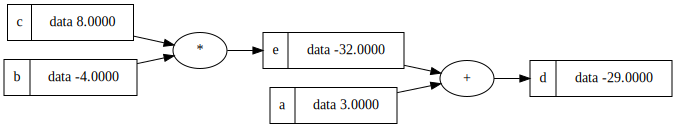

In [35]:
draw_dot(d)

Get gradient $a$ and $e$ manually

In [36]:
# Gradient of a - MANUALLY

# Inputs
a = Value(data=3.0, label='a')
b = Value(data=-4.0, label='b')
c = Value(data=8.0, label='c')
h = 0.0001

# obtain f(x)
e = b*c; e.label = 'e'
d1 = a + e; d1.label = 'd1'

# update a
a.data += h

# obtain f(x+h)
d2 = a + e; d2.label = 'd2'

# get the grad -> dd / da
grad = (d2.data-d1.data)/h
grad

0.9999999999976694

In [37]:
# Gradient of e - MANUALLY

# Inputs
a = Value(data=3.0, label='a')
b = Value(data=-4.0, label='b')
c = Value(data=8.0, label='c')
h = 0.0001

# obtain f(x)
e = b*c; e.label = 'e'
d1 = a + e; d1.label = 'd1'

# update e
e.data += h

# obtain f(x+h)
d2 = a + e; d2.label = 'd2'

# get the grad -> dd / de
grad = (d2.data-d1.data)/h
grad

0.9999999999976694

Get gradient $a$ and $e$ automatically

In [38]:
# Gradient of a - automatically
# Inputs
a = Value(data=3.0, label='a')
b = Value(data=-4.0, label='b')
c = Value(data=8.0, label='c')

# obtain f(x)
e = b*c; e.label = 'e'
d = a + e; d.label = 'd'

In [39]:
# call the backward of d so that we got
# dd / da and dd / de
print(f'grad before :', d.grad, a.grad, e.grad)

# call the backward
d._backward()

print(f'grad after  :', d.grad, a.grad, e.grad)

grad before : 0.0 0.0 0.0
grad after  : 0.0 1.0 1.0


Get gradient $c$ and $b$ manually

In [40]:
# Gradient of b - MANUALLY

# Inputs
a = Value(data=3.0, label='a')
b = Value(data=-4.0, label='b')
c = Value(data=8.0, label='c')
h = 0.0001

# obtain f(x)
e = b*c; e.label = 'e'
d1 = a + e; d1.label = 'd1'

# update b
b.data += h

# obtain f(x+h)
e = b*c; e.label = 'e'
d2 = a + e; d2.label = 'd2'

# get the grad -> dd / da
grad = (d2.data-d1.data)/h
grad

8.000000000016882

In [41]:
# Gradient of c - MANUALLY

# Inputs
a = Value(data=3.0, label='a')
b = Value(data=-4.0, label='b')
c = Value(data=8.0, label='c')
h = 0.0001

# obtain f(x)
e = b*c; e.label = 'e'
d1 = a + e; d1.label = 'd1'

# update c
c.data += h

# obtain f(x+h)
e = b*c; e.label = 'e'
d2 = a + e; d2.label = 'd2'

# get the grad -> dd / da
grad = (d2.data-d1.data)/h
grad

-3.9999999999906777

Get gradient $c$ and $b$ automatically

In [42]:
# Gradient - automatically
# Inputs
a = Value(data=3.0, label='a')
b = Value(data=-4.0, label='b')
c = Value(data=8.0, label='c')

# obtain f(x)
e = b*c; e.label = 'e'
d = a + e; d.label = 'd'

In [43]:
# call the backward of d so that we got
# dd / da and dd / de
print(f'grad before :', d.grad, e.grad, b.grad, c.grad)

# call the backward
d._backward()
e._backward()

print(f'grad after  :', d.grad, e.grad, b.grad, c.grad)

grad before : 0.0 0.0 0.0 0.0
grad after  : 0.0 1.0 8.0 -4.0


What we see in this

- `e.grad` is $\cfrac{dd}{de}$
- `b.grad` is $\cfrac{de}{db}$ not $\cfrac{dd}{db}$
- `c.grad` is $\cfrac{de}{dc}$ not $\cfrac{dd}{dc}$

## **Task 5**
---

- Update the `Value` class so that you can have the derivative of final variables to each previous variables.

Perviously,
- `e.grad` is $\cfrac{dd}{de}$
- `b.grad` is $\cfrac{de}{db}$ not $\cfrac{dd}{db}$
- `c.grad` is $\cfrac{de}{dc}$ not $\cfrac{dd}{dc}$


So, say to find the $\cfrac{dd}{db}$ we have to multiply `c.grad` with the previous grad, i.e. `e.grad`

In [44]:
# Gradient - automatically
# Inputs
a = Value(data=3.0, label='a')
b = Value(data=-4.0, label='b')
c = Value(data=8.0, label='c')

# obtain f(x)
e = b*c; e.label = 'e'
d = a + e; d.label = 'd'

In [45]:
# call the backward of d so that we got
# dd / da and dd / de
print(f'grad before         :', d.grad, e.grad, b.grad, c.grad)

# call the backward
d._backward()
e._backward()

print(f'grad after backward :', d.grad, e.grad, b.grad, c.grad)

# update the grad
e.grad = e.grad * d.grad
b.grad = b.grad * e.grad
c.grad = c.grad * e.grad

print(f'grad after update   :', d.grad, e.grad, b.grad, c.grad)

grad before         : 0.0 0.0 0.0 0.0
grad after backward : 0.0 1.0 8.0 -4.0
grad after update   : 0.0 0.0 0.0 -0.0


why all the value is zero? **because $\cfrac{dd}{dd} = 0.0$ is zero**

$$
\begin{align*}
\cfrac{dd}{dd} &= 0.0 \\
\cfrac{dd}{de} &= \cfrac{dd}{de} \cdot \cfrac{dd}{dd} = (1).(0) = 0.0 \\
\cfrac{dd}{db} &= \cfrac{de}{db} \cdot \cfrac{dd}{de} = (8).(0) = 0.0 \\
\cfrac{dd}{dc} &= \cfrac{de}{dc} \cdot \cfrac{dd}{de} = (-4).(0) = 0.0 \\
\end{align*}
$$

**Solution**: we initialize $\cfrac{dd}{dd} = 1.0$ before backwarding

In [46]:
# Gradient - automatically
# Inputs
a = Value(data=3.0, label='a')
b = Value(data=-4.0, label='b')
c = Value(data=8.0, label='c')

# obtain f(x)
e = b*c; e.label = 'e'
d = a + e; d.label = 'd'

In [47]:
# call the backward of d so that we got
# dd / da and dd / de
print(f'grad before         :', d.grad, e.grad, b.grad, c.grad)

# call the backward
d.grad = 1.0
d._backward()
e._backward()

print(f'grad after backward :', d.grad, e.grad, b.grad, c.grad)

# update the grad
e.grad = e.grad * d.grad
b.grad = b.grad * e.grad
c.grad = c.grad * e.grad

print(f'grad after update   :', d.grad, e.grad, b.grad, c.grad)

grad before         : 0.0 0.0 0.0 0.0
grad after backward : 1.0 1.0 8.0 -4.0
grad after update   : 1.0 1.0 8.0 -4.0


Great, now we have the same results & lets update the `Value` class

In [48]:
# Write your code in here
class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self._prev = set(_children)
        self._op = _op
        self.label = label

        # For automatic differentiation
        self.grad = 0.0
        self._backward = lambda: None

    def __repr__(self):
        return f'Value(data={self.data})'

    def __add__(self, other):
        out = Value(data = self.data + other.data,
                    _children = (self, other),
                    _op = '+')

        # Local grad function
        def _backward():
            # Say C = A + B
            # A = self ; B = other

            # This is dC / dA = 1.0
            # add out.grad      --> dprev / dC
            # then self.grad    --> dprev / dA
            self.grad = 1.0 * out.grad

            # This is dC / dB = 1.0
            other.grad = 1.0 * out.grad

        # Call the local functions
        out._backward = _backward

        return out

    def __mul__(self, other):
        out = Value(data = self.data * other.data,
                    _children = (self, other),
                    _op = '*')

        # Local grad function
        def _backward():
            # Say C = A * B
            # A = self ; B = other

            # This is dC / dA = B
            self.grad = other.data * out.grad

            # This is dC / dB = A
            other.grad = self.data * out.grad

        # Call the local functions
        out._backward = _backward

        return out


Let's validate

In [49]:
# Gradient - automatically
# Inputs
a = Value(data=3.0, label='a')
b = Value(data=-4.0, label='b')
c = Value(data=8.0, label='c')

# obtain f(x)
e = b*c; e.label = 'e'
d = a + e; d.label = 'd'

In [50]:
# call the backward of d so that we got
# dd / da and dd / de
print(f'grad before :', d.grad, e.grad, b.grad, c.grad)

# call the backward
d.grad = 1.0
d._backward()
e._backward()

print(f'grad after  :', d.grad, e.grad, b.grad, c.grad)

grad before : 0.0 0.0 0.0 0.0
grad after  : 1.0 1.0 8.0 -4.0


## **Task 6**
---

- Simplify the `Value` class `backward` operations. Make it run automatically by calling `backward()` method

To solve this, we have to build a topological list of node from final result to first variable then perform `node._backward`

In [51]:
# Gradient - automatically
# Inputs
a = Value(data=3.0, label='a')
b = Value(data=-4.0, label='b')
c = Value(data=8.0, label='c')

# obtain f(x)
e = b*c; e.label = 'e'
d = a + e; d.label = 'd'

In [52]:
# Initialize
topo = []
visited = set()

# create a function to build topology recursively
def build_topo(node):
    if node not in visited:
        # add node
        visited.add(node)

        # visit child recursively
        for child in node._prev:
            build_topo(child)

        # append node to topo
        topo.append(node)

# Run the build_topo
build_topo(node = d)


In [53]:
topo

[Value(data=-4.0),
 Value(data=8.0),
 Value(data=-32.0),
 Value(data=3.0),
 Value(data=-29.0)]

So, the last element of `topo` is our final variables (-29.0). To perform `._backward` we need to reverse the topo order.

In [54]:
# Print grad before
print('Grad before   :', d.grad, e.grad, a.grad, b.grad, c.grad)

# Perform the backward based on reversed topo
d.grad = 1.0
for node in reversed(topo):
    node._backward()

# Print grad after
print('Grad before   :', d.grad, e.grad, a.grad, b.grad, c.grad)

Grad before   : 0.0 0.0 0.0 0.0 0.0
Grad before   : 1.0 1.0 1.0 8.0 -4.0


Great!
Let's wrap it

In [55]:
# Write your code in here
class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self._prev = set(_children)
        self._op = _op
        self.label = label

        # For automatic differentiation
        self.grad = 0.0
        self._backward = lambda: None

    def __repr__(self):
        return f'Value(data={self.data})'

    def __add__(self, other):
        out = Value(data = self.data + other.data,
                    _children = (self, other),
                    _op = '+')

        # Local grad function
        def _backward():
            # Say C = A + B
            # A = self ; B = other

            # This is dC / dA = 1.0
            # add out.grad      --> dprev / dC
            # then self.grad    --> dprev / dA
            self.grad = 1.0 * out.grad

            # This is dC / dB = 1.0
            other.grad = 1.0 * out.grad

        # Call the local functions
        out._backward = _backward

        return out

    def __mul__(self, other):
        out = Value(data = self.data * other.data,
                    _children = (self, other),
                    _op = '*')

        # Local grad function
        def _backward():
            # Say C = A * B
            # A = self ; B = other

            # This is dC / dA = B
            self.grad = other.data * out.grad

            # This is dC / dB = A
            other.grad = self.data * out.grad

        # Call the local functions
        out._backward = _backward

        return out

    def backward(self):
        # Initialize
        topo = []
        visited = set()

        # create a function to build topology recursively
        def build_topo(node):
            if node not in visited:
                # add node
                visited.add(node)

                # visit child recursively
                for child in node._prev:
                    build_topo(child)

                # append node to topo
                topo.append(node)

        # Run the build_topo
        build_topo(node = self)

        # Run the backward operation
        self.grad = 1.0
        for node in reversed(topo):
            node._backward()


Let's validate it

In [56]:
# Gradient - automatically
# Inputs
a = Value(data=3.0, label='a')
b = Value(data=-4.0, label='b')
c = Value(data=8.0, label='c')

# obtain f(x)
e = b*c; e.label = 'e'
d = a + e; d.label = 'd'

In [57]:
# call the backward of d so that we got
# dd / da and dd / de
print(f'grad before :', d.grad, e.grad, b.grad, c.grad)

# call the backward
d.backward()        # call the backward function

print(f'grad after  :', d.grad, e.grad, b.grad, c.grad)

grad before : 0.0 0.0 0.0 0.0
grad after  : 1.0 1.0 8.0 -4.0


Nice!

## **Task 7**
---

- Update the `draw_dot` function so that we can see the gradients on the computational graph

In [58]:
def draw_dot(root):
    """Draw the computational graph by backtracing the operation"""
    # Create a workspace
    dot = Digraph(format='svg',
                  graph_attr={'rankdir': 'LR'})

    # Trace the nodes & edges from computational graph
    nodes, edges = trace(root)

    # Draw
    for node_ in nodes:
        uid = str(id(node_))

        # Create a rectangular node
        # ADD GRAD RESULTS in here
        dot.node(name = uid,
                 label = '{ %s | data %.4f | grad %.4f }' % (node_.label, node_.data, node_.grad),
                 shape = 'record')

        # Create operator (node & edge)
        if node_._op:
            # Create an operation node
            dot.node(name = uid + node_._op,
                     label = node_._op)

            # Connect edge between operation nodes to next value nodes
            dot.edge(tail_name = uid + node_._op,
                     head_name = uid)

    # Create edge for value nodes to operation nodes
    for node_1, node_2 in edges:
        dot.edge(tail_name = str(id(node_1)),
                 head_name = str(id(node_2)) + node_2._op)

    return dot


Let's validate

In [59]:
# Inputs
a = Value(data=3.0, label='a')
b = Value(data=-4.0, label='b')
c = Value(data=8.0, label='c')

# obtain f(x)
e = b*c; e.label = 'e'
d = a + e; d.label = 'd'
d

Value(data=-29.0)

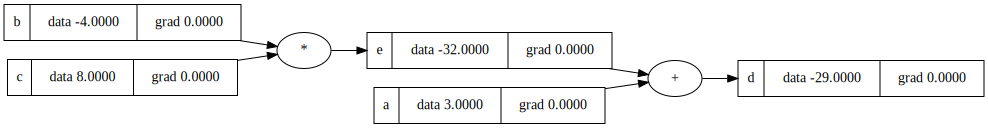

In [60]:
draw_dot(d)

In [61]:
# call the backward of d so that we got
# dd / da and dd / de
print(f'grad before :', d.grad, e.grad, b.grad, c.grad)

# call the backward
d.backward()        # call the backward function

print(f'grad after  :', d.grad, e.grad, b.grad, c.grad)

grad before : 0.0 0.0 0.0 0.0
grad after  : 1.0 1.0 8.0 -4.0


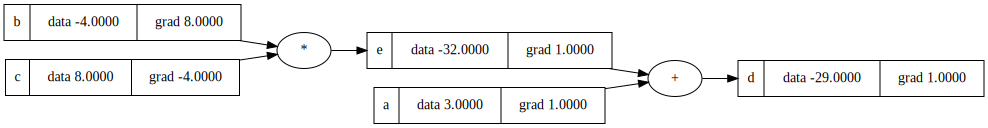

In [62]:
draw_dot(d)

## **Task 8**
---

- Fix the bug on `Value` class `backward`

Let's solve this. Say you want to differentiate a simple equation

$$
b = a + a
$$

then
$$
\cfrac{db}{da} = 2.0
$$

Let's find its differentation with our computational graph

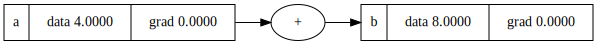

In [63]:
# input
a = Value(data=4.0, label='a')
b = a + a; b.label='b'

draw_dot(b)

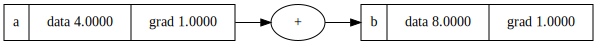

In [64]:
# Lets do the backward
b.backward()

draw_dot(b)

The $\cfrac{db}{da}$ should be 2.0

Why is this happen? **Because we do not accumulate the grad of similar variables**

So, instead of using `self.grad = <grad> * out.grad` we will do `self.grad += <grad> * out.grad`.

Let's update the class!

In [65]:
# Write your code in here
class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self._prev = set(_children)
        self._op = _op
        self.label = label

        # For automatic differentiation
        self.grad = 0.0
        self._backward = lambda: None

    def __repr__(self):
        return f'Value(data={self.data})'

    def __add__(self, other):
        out = Value(data = self.data + other.data,
                    _children = (self, other),
                    _op = '+')

        # Local grad function
        def _backward():
            # Say C = A + B
            # A = self ; B = other

            # This is dC / dA = 1.0
            # add out.grad      --> dprev / dC
            # then self.grad    --> dprev / dA
            self.grad += 1.0 * out.grad

            # This is dC / dB = 1.0
            other.grad += 1.0 * out.grad

        # Call the local functions
        out._backward = _backward

        return out

    def __mul__(self, other):
        out = Value(data = self.data * other.data,
                    _children = (self, other),
                    _op = '*')

        # Local grad function
        def _backward():
            # Say C = A * B
            # A = self ; B = other

            # This is dC / dA = B
            self.grad += other.data * out.grad

            # This is dC / dB = A
            other.grad += self.data * out.grad

        # Call the local functions
        out._backward = _backward

        return out

    def backward(self):
        # Initialize
        topo = []
        visited = set()

        # create a function to build topology recursively
        def build_topo(node):
            if node not in visited:
                # add node
                visited.add(node)

                # visit child recursively
                for child in node._prev:
                    build_topo(child)

                # append node to topo
                topo.append(node)

        # Run the build_topo
        build_topo(node = self)

        # Run the backward operation
        self.grad = 1.0
        for node in reversed(topo):
            node._backward()


Let's validate

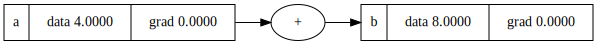

In [66]:
# input
a = Value(data=4.0, label='a')
b = a + a; b.label='b'

draw_dot(b)

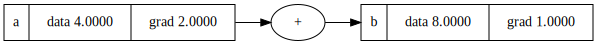

In [67]:
# Lets do the backward
b.backward()

draw_dot(b)

Great!

## **Exercise**
---

Given a linear regression function

$$
y = w_{0} + w_{1}x_{1} + w_{2}x_{2}
$$

Your tasks are:
1. Create a computational graph to find $y$ where
  - $w = [0.9, 0.01, 0.2]$
  - $x = [1.0, -1.0]$

2. Draw the computational graph
3. Find the gradient of $y$ with respect to each model parameters

In [68]:
# Create an input
x1 = Value(data=1.0, label='x1')
x2 = Value(data=-1.0, label='x2')

w0 = Value(data=0.9, label='w0')
w1 = Value(data=0.01, label='w1')
w2 = Value(data=0.2, label='w2')

In [69]:
# Create a computational graph
w1x1 = w1 * x1; w1x1.label = 'w1x1'
w2x2 = w2 * x2; w2x2.label = 'w2x2'
w1x1w2x2 = w1x1 + w2x2; w1x1w2x2.label = 'w1x1 + w2x2'

y = w0 + w1x1w2x2; y.label = 'y'
y

Value(data=0.71)

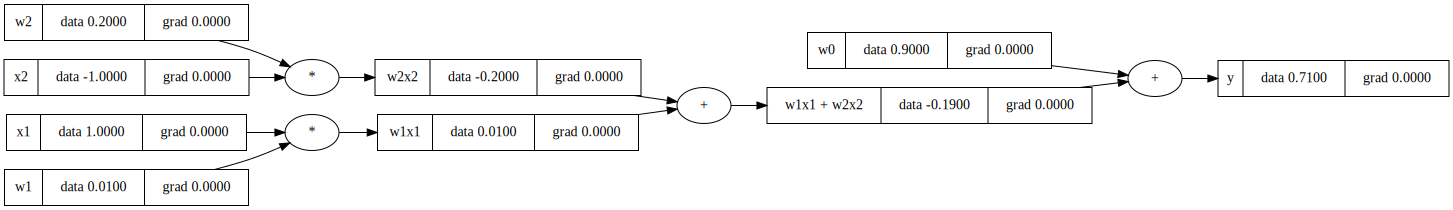

In [70]:
# Draw the computational graph
draw_dot(root = y)

In [71]:
# Take the grad
y.backward()

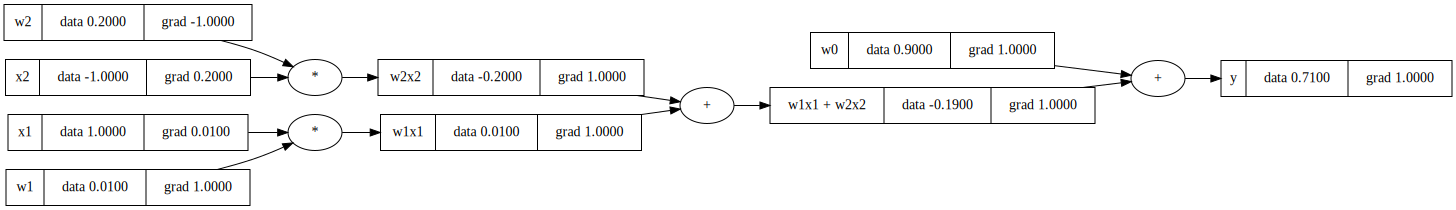

In [72]:
# Draw the computational graph
draw_dot(root = y)